# 0. Imports

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(rc={'figure.figsize':(12,8)})

## Helper Functions

In [3]:
def create_descriptive_statistics_table(dataframe, remove_columns = None):
    df_numerical = dataframe.select_dtypes(include=['int64', 'float64'])
    
    if remove_columns != None and isinstance(remove_columns, list):
        df_numerical = df_numerical.drop(remove_columns, axis=1)
        
    df_min = pd.DataFrame(df_numerical.apply(np.min)).T
    df_max = pd.DataFrame(df_numerical.apply(np.max)).T
    df_range = pd.DataFrame(df_numerical.apply(lambda column: column.max() - column.min())).T
    df_mean = pd.DataFrame(df_numerical.apply(np.mean)).T
    df_median = pd.DataFrame(df_numerical.apply(np.median)).T
    df_std = pd.DataFrame(df_numerical.apply(np.std)).T
    df_skew = pd.DataFrame(df_numerical.apply(lambda x: x.skew())).T
    df_kurtosis = pd.DataFrame(df_numerical.apply(lambda x: x.kurtosis())).T
    
    df = pd.concat([df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis]).T.reset_index()
    df.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return df

# 1. Projeto de Insights - House Rocket

## 1.1. Questões de Negócio

1. Quais são os imóveis que a House Rocket deveria comprar e por qual preço ?
2. Uma vez a casa comprada, qual o melhor momento para vendê-las e por qual preço ?

## 1.2. Entendimento do Negócio

1. Quais são os imóveis que a House Rocket deveria comprar e por qual preço ?
   - Plano 01:
      - Coletar e limpar os dados.
      - Agrupar os imóveis por região ( zipcode ).
      - Dentro de cada região, será encontrado a mediana do preço do imóvel.
      - Será sugerido os imóveis que estão abaixo do preço mediano da região, que estejam em boas condições e tenham vista para água.
      - Exemplo de Relatório entregue:
            
| Imóvel Cod | Região | Preço do Imóvel | Preço na Mediana | Condições | Status |
| ---------- | ------ | --------------: | ---------------: | --------- | :----: |
| 10330 | Vila Olímpia | R\$ 450.000,00 | R\$ 500.000,00 | 3 | Compra |
| 10335 | Vila Olímpia | R\$ 750.000,00 | R\$ 500.000,00 | 3 | Não Compra |
| 10335 | Vila Olímpia | R\$ 150.000,00 | R\$ 500.000,00 | 1 | Não Compra |

2. Uma vez a casa comprada, qual o melhor momento para vendê-las e por qual preço ?
   - Plano 01:
     - Coletar e limpar os dados (Etapa já cumprida na tarefa anterior).
     - Agrupar os imóveis por região (zipcode) e por sazonalidade (Summer, Inter).
     - Dentro de cada região e sazonalidade, será calculado a mediana do preço.
     - As condições de venda serão:
         1. Se o preço da compra for maior que a mediana da região + sazonalidade. O preço da venda será igual ao preço da compra + 10%
         2. Se o preço da compra for menor que a mediana da região + sazonalidade. O preço da venda será igual ao preço da compra + 30%
     - Exemplo do relatório entregue:


| Imóvel Cod | Região | Temporada | Preço da Mediana | Preço de Compra | Preço de Venda | Lucro | 
| ---------- | :----- | :---------| ---------------: | --------------: | -------------: | ----: |
| 10330 | Vila Olímpia | Verão | R\$ 800.000,00 | R\$ 450.000,00 | R\$ 585.000,00 | R\$ 135.000,00 |
| 10335 | Vila Olímpia | Inverno | R\$ 400.000,00 | R\$ 500.000,00 | R\$ 500.000,00 | R\$ 50.000,00 |

## 1.3. - Coleta dos dados

### 1.3.1. Carregamento dos Dados

In [4]:
df_raw = pd.read_csv('../datasets/kc_house_data.csv')
df_raw.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### 1.3.2. Descrição dos Dados

| Nome da Coluna | Descrição da Coluna |
| :------------- | :------------------ |
| id | ID único de cada imóvel na base de dados |
| date | Data da venda do imóvel |
| price | Preço de venda do imóvel |
| bedrooms | Número de quartos |
| bedrooms | Número de banheiros. Onde 0.5 representa um quarto com vaso sanitário, mas sem chuveiro; 0.75 representa um banheiro que contém uma pia, uma privada, um chuveiro ou uma banheira. Um banheiro completo tradicionalmente possui uma pia, uma privada, um chuveiro e uma banheira, dessa forma, 0.75 representa que o banheiro tem ou um chuveiro ou uma banheira |
| sqft_living | Metragem quadrada (em pés) do espaço interior do imóvel |
| sqft_lot | Metragem quadrada (em pés) do espaço terrestre do imóvel |
| floors | Número de andares do imóvel |
| waterfront | Coluna que representa se o imóvel possui vista para o mar/lago ou não. 0 representa sem vista para a água e 1 representa vista para a água |
| view | Índice de 0 a 4 de quão boa é a vista do imóvel. 0 é a pior vista e 4 é a melhor vista |
| condition | Índice de 1 a 5 sobre a condição (usado) do imóvel. 1 é a pior condição e 5 é a melhor |
| grade	| Índice de 1 a 13 sobre a condição da construção e design do imóvel. 1 é a pior nota e 13 é a melhor nota |
| sqft_above | Metragem quadrada (em pés) do espaço interno do imóvel que está acima do nível do solo |
| sqft_basement | Metragem quadrada (em pés) do espaço interno do imóvel que está abaixo do nível do solo (porão) |
| yr_built | Ano em que o imóvel foi construído |
| yr_renovated | Ano da última reforma do imóvel |
| zipcode | Código postal do imóvel |
| lat | Ponto de latitude do imóvel |
| long | Ponto de longitude do imóvel |
| sqft_living15 | Metragem quadrada (em pés) do espaço habitacional interior para os 15 vizinhos mais próximos |
| sqft_lot15 | A metragem quadrada (em pés) dos terrenos (lotes vazios) dos 15 vizinhos mais próximos |

### 1.3.3. Verificação de NAs e tipos dos Dados

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

Como não temos dados faltantes, iremos verificar primeiro a tabela de estatística descritiva para verificar as inconsistencias e depois limpar os dados, caso necessário.

Além disso, precisamos arrumar a coluna `date` para o tipo de data.

### 1.3.4. Tabela de Estatística descritiva

In [6]:
df_numerical = create_descriptive_statistics_table(df_raw, ['id', 'lat', 'long'])
df_numerical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,75000.0,7700000.0,7625000.0,540088.141767,450000.00,367118.703181,4.024069,34.585540
1,bedrooms,0.0,33.0,33.0,3.370842,3.00,0.930040,1.974300,49.063653
2,bathrooms,0.0,8.0,8.0,2.114757,2.25,0.770145,0.511108,1.279902
3,sqft_living,290.0,13540.0,13250.0,2079.899736,1910.00,918.419649,1.471555,5.243093
4,sqft_lot,520.0,1651359.0,1650839.0,15106.967566,7618.00,41419.553273,13.060019,285.077820
5,floors,1.0,3.5,2.5,1.494309,1.50,0.539976,0.616177,-0.484723
6,waterfront,0.0,1.0,1.0,0.007542,0.00,0.086515,11.385108,127.632494
7,view,0.0,4.0,4.0,0.234303,0.00,0.766300,3.395750,10.893022
8,condition,1.0,5.0,4.0,3.409430,3.00,0.650728,1.032805,0.525764
9,grade,1.0,13.0,12.0,7.656873,7.00,1.175432,0.771103,1.190932


Como podemos observar, temos imóveis que não possuem nem banheiros e nem quartos (valores mínimos iguais a zero). Na limpeza, esses imóveis serão removidos. Limparemos também o registro que tem 33 quartos.

### 1.3.3. Limpeza dos Dados

In [7]:
df1 = df_raw.loc[df_raw['bedrooms'] > 0, :]
df1 = df1.loc[df1['bedrooms'] < 33, :]
df1 = df1.loc[df1['bathrooms'] > 0, :]

#### 1.3.4. Estatistica Descritiva

#### 1.3.4.1. Variáveis Numéricas

In [8]:
df_numerical = create_descriptive_statistics_table(df1, ['id', 'lat', 'long'])
df_numerical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,78000.0,7700000.0,7622000.0,540198.298666,450000.00,367133.102791,4.025670,34.602960
1,bedrooms,1.0,11.0,10.0,3.371828,3.00,0.904093,0.551382,1.797482
2,bathrooms,0.5,8.0,7.5,2.115843,2.25,0.768980,0.519644,1.279159
3,sqft_living,370.0,13540.0,13170.0,2080.343165,1910.00,918.100781,1.473143,5.251772
4,sqft_lot,520.0,1651359.0,1650839.0,15099.830107,7619.00,41412.590583,13.072315,285.483214
5,floors,1.0,3.5,2.5,1.494119,1.50,0.539672,0.614427,-0.491124
6,waterfront,0.0,1.0,1.0,0.007548,0.00,0.086549,11.380527,127.528204
7,view,0.0,4.0,4.0,0.234303,0.00,0.766388,3.396138,10.894949
8,condition,1.0,5.0,4.0,3.409752,3.00,0.650456,1.036107,0.519838
9,grade,3.0,13.0,10.0,7.657946,7.00,1.173191,0.788166,1.134991


### 1.3.5. Ajuste de Tipos

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [10]:
df1.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## 1.4. Exploração dos Dados

1. Descobrir Insights para o time de negócio.
2. Explorar os dados para identificar o impacto dos atributos nos algoritmos de ML.
3. O que são Insights para o negócio?
    - Insights são descobertas, através dos dados, que são inesperada pelas pessoas.
    - Insight precisa ser acionável, caso contrário, ele é apenas uma curiosidade.
    - Exemplo:
        * Durante o período de natal vendê-se mais casas do que na páscoa ( Descoberta )
        * Imóveis com porão são maiores do que imóveis sem porão ( Não-acionável )
        * Imóveis com porão são 40% mais caros do que os outros, na média ( Acionável - Compra imóveis sem porão )
4. Como fazemos para criar as hipóteses ?
    - Toda hipótese de negócio precisa ter 3 características:
        1. Precisa ser uma afirmação.
        2. Precisa fazer uma comparação entre 2 variáveis.
        3. Precisa de um valor base.
        4. Exemplo:
            * H1: Imóveis que possuem vista para água, são 30% mais caros, na média.
            * H2: Imóveis com data de construção menor que 1955, são 50% mais baratos, na média.
            * H3: Imóveis sem porão possuem sqrt_lot, são 50% maiores do que com porão.
            * H4: O crescimento do preço dos imóveis YoY ( Year over Year ) é de 10%
            * H5: Imóveis com 3 banheiros tem um crescimento MoM ( Month over Month ) de 15%

### 1.4.1. Hipóteses

#### H1: Imóveis que possuem vista para água, são 30% mais caros, na média.

In [11]:
df_grouped_waterfront = df1.loc[:, ['waterfront', 'price']].groupby('waterfront').agg(
    mean_price = pd.NamedAgg('price', 'mean')
)

df_grouped_waterfront = df_grouped_waterfront.sort_values('mean_price', ascending=False).reset_index()

df_grouped_waterfront['mean_price'] = df_grouped_waterfront['mean_price'].apply(lambda x: float(f'{x:.2f}') )
df_grouped_waterfront['waterfront'] = df_grouped_waterfront['waterfront'].apply(lambda x: 'Yes' if x == 1 else 'No')

df_grouped_waterfront

,waterfront,mean_price
0,Yes,1661876.02
1,No,531667.83


In [12]:
with_view = df_grouped_waterfront.iloc[0, 1]
with_no_view = df_grouped_waterfront.iloc[1, 1]

print(f'Os imóveis com vista para a água são { round( ((with_view * 100) / with_no_view) - 100, 2)}% mais caros que os imóveis sem vista para a água')

Os imóveis com vista para a água são 212.58% mais caros que os imóveis sem vista para a água


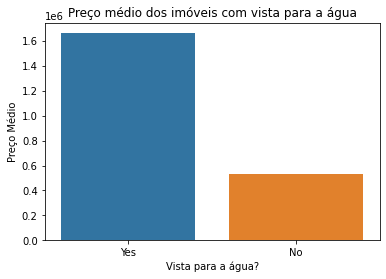

In [13]:
from typing import Container


ax = sns.barplot(
    data = df_grouped_waterfront,
    x = 'waterfront',
    y = 'mean_price',
)

ax = ax.set(
    xlabel = 'Vista para a água?',
    ylabel = 'Preço Médio',
    title = 'Preço médio dos imóveis com vista para a água'
)

**Hipótese Verdadeira**. Como podemos observar, os imóveis que possuem vista para a água são mais de 30% mais caros que os imóveis que possuem vista para a água.

#### H2: Imóveis com data de construção menor que 1955, são 50% mais baratos, na média.

In [14]:
df_year_before = df1.loc[df1['yr_built'] < 1955, :]
df_year_after = df1.loc[~df1['yr_built'] < 1955, :]

year_before_price_mean = df_year_before.loc[:, 'price'].mean()
year_after_price_mean = df_year_after.loc[:, 'price'].mean()

print(f'O valor da média do preço das casas construídas antes de 1955 é de $ {year_before_price_mean:.2f}')
print(f'O valor da média do preço das casas construídas depois de 1955 é de $ {year_after_price_mean:.2f}')
print(f'Os imóveis construídos antes de 1955 são {round( 100 - ( ( year_before_price_mean * 100) / year_after_price_mean ), 2)}% mais baratos')

O valor da média do preço das casas construídas antes de 1955 é de $ 537199.20
O valor da média do preço das casas construídas depois de 1955 é de $ 540198.30
Os imóveis construídos antes de 1955 são 0.56% mais baratos


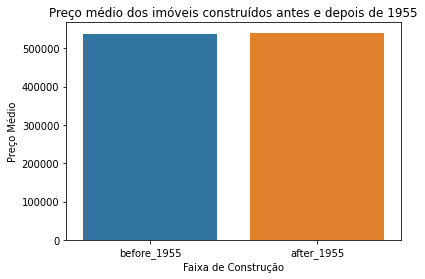

In [15]:
df_construction = pd.DataFrame([
    {'year_contruction_range': 'before_1955', 'mean_price': year_before_price_mean},
    {'year_contruction_range': 'after_1955', 'mean_price': year_after_price_mean},
])

ax = sns.barplot(
    data = df_construction,
    x = 'year_contruction_range',
    y = 'mean_price',
)

ax = ax.set(
    xlabel = 'Faixa de Construção',
    ylabel = 'Preço Médio',
    title = 'Preço médio dos imóveis construídos antes e depois de 1955'
)

**Hipótese Falsa**: Como podemos observar, os imóveis construídos antes de 1955 não são 50% mais baratos que os imóveis construídos depois de 1955.

#### H3: Imóveis sem porão são 50% maiores, na média, do que os imóveis com porão.

In [16]:
df_has_basement = df1.loc[df1['sqft_basement'] > 0, :]
df_no_basement = df1.loc[df1['sqft_basement'] <= 0, :]

sqft_lot_with_basement_mean = df_has_basement.loc[:, 'sqft_lot'].mean()
sqft_lot_no_basement_mean = df_no_basement.loc[:, 'sqft_lot'].mean()

print(f'O tamanho médio dos terrenos com porão é de {sqft_lot_with_basement_mean:.2f} pés quadrados')
print(f'O tamanho médio dos terrenos sem porão é de {sqft_lot_no_basement_mean:.2f} pés quadrados')
print(f'Os imóveis com porão são {round( 100 - ( ( sqft_lot_with_basement_mean * 100) / sqft_lot_no_basement_mean ), 2)}% maiores que os imóveis sem porão')

O tamanho médio dos terrenos com porão é de 13287.15 pés quadrados
O tamanho médio dos terrenos sem porão é de 16273.16 pés quadrados
Os imóveis com porão são 18.35% maiores que os imóveis sem porão


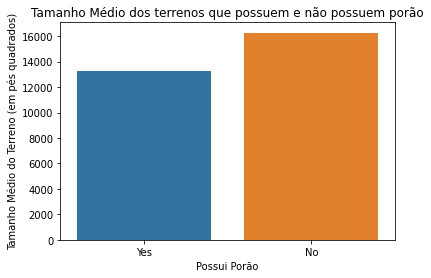

In [17]:
df_basement = pd.DataFrame([
    {'with_basement': 'Yes', 'mean_size': sqft_lot_with_basement_mean},
    {'with_basement': 'No', 'mean_size': sqft_lot_no_basement_mean},
])

ax = sns.barplot(
    data = df_basement,
    x = 'with_basement',
    y = 'mean_size',
)

ax = ax.set(
    xlabel = 'Possui Porão',
    ylabel = 'Tamanho Médio do Terreno (em pés quadrados)',
    title = 'Tamanho Médio dos terrenos que possuem e não possuem porão'
)

**HIPÓTESE FALSA**: Como podemos observar, os terrenos que não possuem porão não são 50% maiores que os terrenos que possuem porão.

#### H4: O crescimento do preço médio dos imóveis YoY ( Year over Year ) é de 10%

In [26]:
df_aux = df1.copy()

df_aux['year_sell'] = df_aux['date'].dt.year

df_year_grouped = df_aux.loc[ :, ['year_sell', 'price'] ].groupby('year_sell').agg(
    mean_price = pd.NamedAgg('price', 'mean')
)

df_year_grouped = df_year_grouped.sort_values('year_sell').reset_index()

df_year_grouped['mean_price'] = df_year_grouped['mean_price'].apply(lambda x: float(f'{x:.2f}') )

initial_price = df_year_grouped.iloc[0,1]

df_year_grouped['growth'] = df_year_grouped['mean_price'].apply(lambda x: round( ( ((x * 100) / initial_price) - 100), 2) )

df_year_grouped

,year_sell,mean_price,growth
0,2014,539245.55,0.00
1,2015,542195.44,0.55


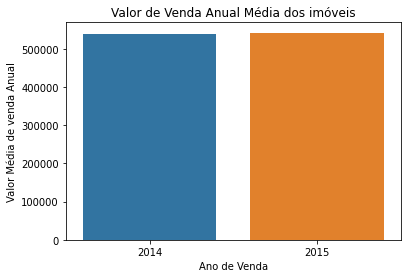

In [27]:
ax = sns.barplot(
    data = df_year_grouped,
    x = 'year_sell',
    y = 'mean_price',
)

ax = ax.set(
    xlabel = 'Ano de Venda',
    ylabel = 'Valor Média de venda Anual',
    title = 'Valor de Venda Anual Média dos imóveis'
)

**Hipótese Falsa**: O crescimento do preço médio YoY não é de 10%

#### H5: Imóveis com 3 banheiros tem um crescimento MoM ( Month over Month ) de 15%

In [42]:
df_aux = df1.copy()

df_aux = df_aux.loc[df1['bathrooms'] == 3, :]

df_aux['period'] = df_aux['date'].dt.to_period("M")

df_year_grouped = df_aux.loc[ :, ['period', 'price'] ].groupby('period').agg(
    mean_price = pd.NamedAgg('price', 'mean')
)

df_year_grouped = df_year_grouped.sort_values('period').reset_index()

df_year_grouped['mean_price'] = df_year_grouped['mean_price'].apply(lambda x: float(f'{x:.2f}') )

initial_price = df_year_grouped.iloc[0,1]

df_year_grouped['growth'] = df_year_grouped['mean_price'].apply(lambda x: round( ( ((x * 100) / initial_price) - 100), 2) )

df_year_grouped

,period,mean_price,growth
0,2014-05,690080.71,0.00
1,2014-06,775057.56,12.31
2,2014-07,741405.04,7.44
3,2014-08,737576.56,6.88
4,2014-09,645246.89,-6.50
5,2014-10,645523.02,-6.46
6,2014-11,679910.47,-1.47
7,2014-12,728341.19,5.54
8,2015-01,672923.17,-2.49
9,2015-02,696714.42,0.96


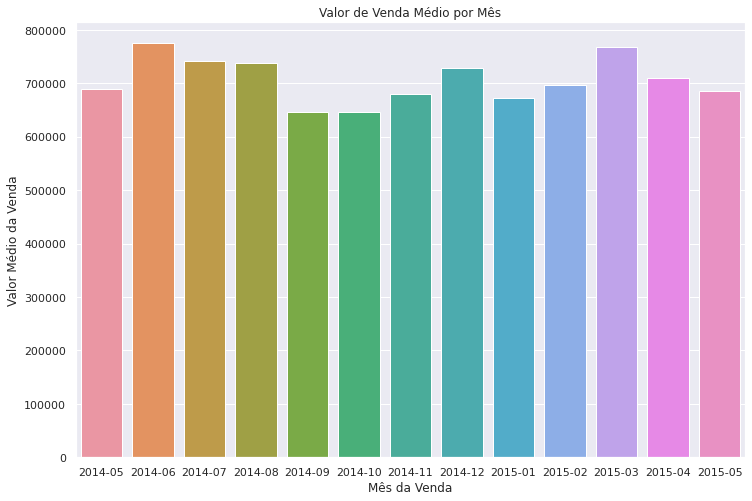

In [52]:
ax = sns.barplot(
    data = df_year_grouped,
    x = 'period',
    y = 'mean_price',
)

ax = ax.set(
    xlabel = 'Mês da Venda',
    ylabel = 'Valor Médio da Venda',
    title = 'Valor de Venda Médio por Mês'
)

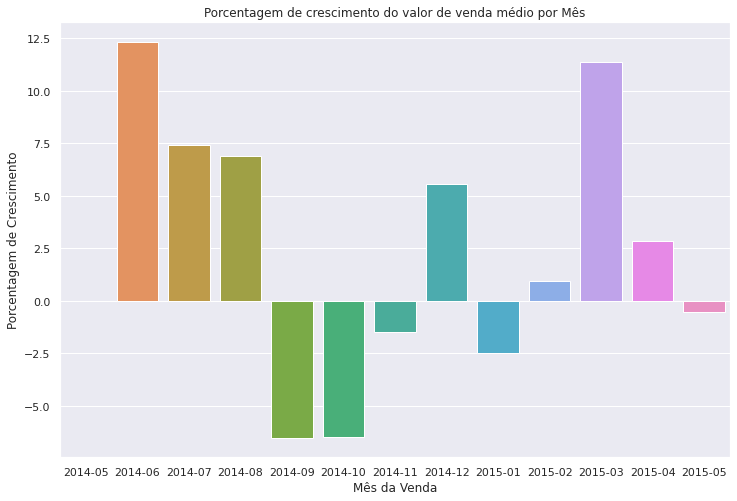

In [53]:
ax = sns.barplot(
    data = df_year_grouped,
    x = 'period',
    y = 'growth',
)

ax = ax.set(
    xlabel = 'Mês da Venda',
    ylabel = 'Porcentagem de Crescimento',
    title = 'Porcentagem de crescimento do valor de venda médio por Mês'
)

**Hipótese Falsa**: O percentual de crescimento mensal do valor de venda nunca atingiu 15%

#### H6: Imóveis com porão são mais caros, em média, do que imóveis sem porão

In [48]:
df_has_basement = df1.loc[df1['sqft_basement'] > 0, :]
df_no_basement = df1.loc[df1['sqft_basement'] <= 0, :]

apt_with_basement_mean = df_has_basement.loc[:, 'price'].mean()
apt_no_basement_mean = df_no_basement.loc[:, 'price'].mean()

print(f'Imóveis com porão tem um preço médio de $ {apt_with_basement_mean:.2f}')
print(f'Imóveis sem porão tem um preço médio de $ {apt_no_basement_mean:.2f}')
print(f'Os imóveis com porão são {round( 100 - ( ( apt_no_basement_mean * 100) / apt_with_basement_mean ), 2)}% mais caros que os imóveis sem porão')

Imóveis com porão tem um preço médio de $ 622371.49
Imóveis sem porão tem um preço médio de $ 487008.24
Os imóveis com porão são 21.75% mais caros que os imóveis sem porão


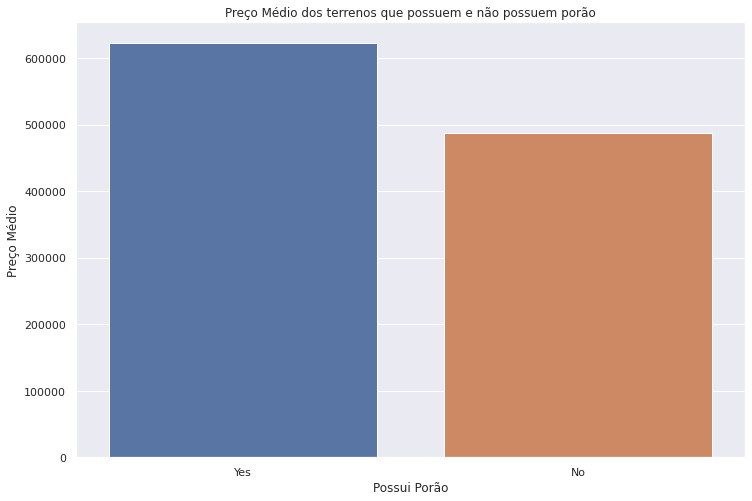

In [54]:
df_basement = pd.DataFrame([
    {'with_basement': 'Yes', 'mean_price': apt_with_basement_mean},
    {'with_basement': 'No', 'mean_price': apt_no_basement_mean},
])

ax = sns.barplot(
    data = df_basement,
    x = 'with_basement',
    y = 'mean_price',
)

ax = ax.set(
    xlabel = 'Possui Porão',
    ylabel = 'Preço Médio',
    title = 'Preço Médio dos terrenos que possuem e não possuem porão'
)

**hipótese Verdadeira**: Como podemos observar, os imóveis com porão possuem um preço médio maior que os imóveis sem porão

#### H7: Imóveis reformados recentemente tem valor mais alto

#### H8: Imóveis com vista para água, na média, são 20% mais caros

#### H9: Pelo menos 80% dos imóveis com vista para água possuem nível de construção 10 ou mais.

#### H10: Imóveis no vendidos no inverno são, em média, são 20% mais baratos do que no resto do ano.